In [1]:
import numpy as np
import pandas as pd
import semopy as sem

# ============================================================
# 1. 合成データの生成（因果構造を意識したシミュレーション）
# ============================================================
# 今回は「TVCM と気温が炭酸飲料の売上に影響を与える」という
# 単純な因果ストーリーを仮定したうえで、
#
#   Soda_Sales = β0 + β1 * TV_CM + β2 * Temperature_C + 誤差
#
# という線形モデルに従うデータを自前で生成している。
# 後で SEM（構造方程式モデリング）でこの関係を推定することを想定しており、
# 真のパラメータを自分で決めた「おもちゃデータ」を用いることで、
# 推定結果が理論通りに回復しているかを検証できるようにしている。
# ============================================================

# 乱数のシードを設定（再現性のため）
# - 同じコードを何度実行しても同じ乱数系列を得られるようにする。
# - シミュレーションや検証実験では、結果の再現性確保のために必須。
np.random.seed(0)

# サンプルサイズ N
# - 観測データの行数（≒母集団からのサンプリング数）を 200 に設定。
# - N が大きいほど推定量の分散は小さくなるが、ここでは手軽な規模を選択。
N = 200

# ------------------------------------------------------------
# 説明変数 1: TV_CM
# ------------------------------------------------------------
# TVCM（テレビCMの視聴者関心度［独自指標］）のデータを生成。
# - 正規分布 N(平均 50, 標準偏差 10) に従うと仮定。
# - 「広告露出の強さ」や「視聴者の関心度」を数値化した指標をイメージしている。
#   例えば、GRP（延べ視聴率）やブランドリフトのスコアなど。
TV_CM = np.random.normal(50, 10, N)

# ------------------------------------------------------------
# 説明変数 2: Temperature_C
# ------------------------------------------------------------
# 気温（Temperature_C、摂氏）のデータを一様分布で生成。
# - 10〜35℃の範囲の一様分布 U(10, 35) とする。
# - 「暑くなるほど炭酸飲料が売れやすい」という現実的な仮定に対応。
Temperature_C = np.random.uniform(10, 35, N)

# ------------------------------------------------------------
# 誤差項（ノイズ）の生成
# ------------------------------------------------------------
# ノイズ（Noise）はモデル化されていない要因（例: 競合キャンペーン、イベント、
# 店頭プロモーションなど）をまとめて表す。
# - 平均 0, 標準偏差 5 の正規分布 N(0, 5) を仮定。
# - 期待値 0 とすることで、回帰式の切片 β0 が
#   「その他の平均的な要因の影響」を表すようになる。
Noise = np.random.normal(0, 5, N)

# ------------------------------------------------------------
# 目的変数: Soda_Sales（炭酸飲料の売上）
# ------------------------------------------------------------
# 炭酸飲料の売上を線形モデルで生成する。
#   Soda_Sales = 10 + 0.5 * TV_CM + 2.0 * Temperature_C + Noise
#
# 理論的な意味:
# - β0 = 10:
#     全ての説明変数が 0 のときの基準売上（ベースライン）。
# - β1 = 0.5:
#     TVCM 指標が 1 単位増えると、平均的に売上が 0.5 単位増える、
#     という「TVCM → 売上」の因果効果（構造係数）を想定。
# - β2 = 2.0:
#     気温が 1℃ 上がると、平均的に売上が 2.0 単位増える、
#     という「気温 → 売上」の因果効果を想定。
#
# ここでの重要ポイントは、
# - 我々は「真のパラメータ（0.5, 2.0）」を知っている立場にいるので、
# - この合成データに対して回帰や SEM を適用した結果が、
#   どの程度この真値を回復できるかを検証できること。
Soda_Sales = 10 + 0.5 * TV_CM + 2.0 * Temperature_C + Noise

# ------------------------------------------------------------
# データフレームへのまとめ
# ------------------------------------------------------------
# pandas.DataFrame にまとめることで、
# - 回帰分析（statsmodels, scikit-learn）
# - SEM（semopy）
# - 可視化（matplotlib, seaborn）
# など、後続の分析ライブラリとスムーズに連携できる形式になる。
data = pd.DataFrame(
    {"TV_CM": TV_CM, "Temperature_C": Temperature_C, "Soda_Sales": Soda_Sales}
)

# ここまでで、
# - 列 TV_CM, Temperature_C が「説明変数」（原因側の変数）
# - 列 Soda_Sales が「目的変数」（結果・アウトカム）
# という因果構造を持った合成データセットが完成している。
# この data を使って、今後 semopy で
#   Soda_Sales ~ TV_CM + Temperature_C
# のような構造方程式モデルを推定することができる。

In [2]:
# ============================================================
# SEM（構造方程式モデリング）で用いるモデル記述の定義
# ============================================================
# semopy では、R の lavaan 風の「モデル記述言語」を文字列で書いて
# 構造方程式モデルを定義する。
#
# 基本ルール（今回使う部分）:
#   y ~ x1 + x2 + ...
#     → 「従属変数 y が、x1, x2, ... によって回帰される」
#       という回帰（構造方程式）を表す。
#
# ここでは、合成データ生成時に仮定した構造
#
#   Soda_Sales = β0 + β1 * TV_CM + β2 * Temperature_C + 誤差
#
# を、そのまま SEM の構造部分として記述している。
# つまり、TVCM と気温が炭酸飲料売上の「直接原因」になるという
# 因果構造を、線形モデルの形で SEM に教えていることになる。
#
# ※今回のモデルは「測定モデル（潜在変数）なし」のシンプルな
#   回帰型 SEM（構造方程式だけを持つパス解析）に相当する。
model_desc = """
# 回帰分析（構造方程式）
# Soda_Sales を従属変数、TV_CM と Temperature_C を説明変数とする回帰。
# SEM の文脈では、これは「Soda_Sales への入ってくるパス」を定義している。
Soda_Sales ~ TV_CM + Temperature_C
"""

In [3]:
# ============================================================
# SEM モデルの構築と推定（フィッティング）
# ============================================================
# ここまでで用意してきたもの：
# - model_desc : SEM の構造を記述した文字列
#     Soda_Sales ~ TV_CM + Temperature_C
# - data       : 合成データ（TV_CM, Temperature_C, Soda_Sales の 3 列）
#
# ここでは semopy を用いて、
#   1. モデルオブジェクトの構築（Model）
#   2. 観測データへの当てはめ（fit）
#   3. 推定結果の表示（print）
# を行う。
#
# 理論的には、SEM のフィッティングは
#   - 共分散構造 Σ(θ) とサンプル共分散 S の「距離」を最小化する問題
#   - 最尤推定（ML）や GLS 等の基準でパラメータ θ（係数）を推定
# を解いていると解釈できる。
# 今回のように単純な回帰型モデルの場合は、
# 「Soda_Sales を目的変数とする線形回帰」を SEM フレームワークの中で
# 行っていることに相当する。
# ============================================================

# ------------------------------------------------------------
# 1. SEM モデルオブジェクトの構築
# ------------------------------------------------------------
# sem.Model は、model_desc で記述した構造方程式モデルを内部表現に変換し、
# - 変数（観測変数・潜在変数）
# - パラメータ（回帰係数、分散・共分散）
# - 制約（=, ~, =~ など）
# などの情報を保持するクラス。
#
# ここでは
#   Soda_Sales ~ TV_CM + Temperature_C
# という 1 本の構造方程式のみを含むシンプルなパス解析モデルになる。
mod = sem.Model(model_desc)

# ------------------------------------------------------------
# 2. モデルのフィッティング（推定）
# ------------------------------------------------------------
# mod.fit(data) では、観測データ data に対して
#   - 目的関数（例えば最尤法：サンプル共分散とモデル共分散の差を最小化）
#   - 最適化アルゴリズム（勾配法など）
# を用いて、パラメータ（回帰係数・誤差分散 等）を推定する。
#
# このとき、本コードでは合成データ生成時に
#   Soda_Sales = 10 + 0.5 * TV_CM + 2.0 * Temperature_C + Noise
# という「真の構造」を使っているので、
# 推定結果の係数（β1, β2）が 0.5, 2.0 に近い値になるかどうかを確認することで、
# - 推定器のバイアスが小さいか
# - サンプルサイズ N=200 でどの程度の推定誤差が出るか
# を評価できる。
res = mod.fit(data)

# ------------------------------------------------------------
# 3. 推定結果の表示
# ------------------------------------------------------------
# print(res) では、semopy が返すフィット結果の概要（fit statistics など）が表示される。
# 多くの場合、
#   - 収束ステータス
#   - 目的関数値
#   - 主要な適合度指標（CFI, RMSEA など）
# が表示される。
#
# さらに詳細なパラメータ推定値（回帰係数や分散など）を確認したい場合は、
#   sem.inspector.inspect(mod)
# などを用いることで、推定された β1, β2 が真値（0.5, 2.0）にどれくらい
# 近いかを数値として確認できる。
print(res)

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 0.000
Number of iterations: 12
Params: 0.513 2.043 26.145


In [4]:
# ============================================================
# モデル適合度指標（fit indices）の計算と表示
# ============================================================
# semopy.calc_stats(mod) は、推定済みの SEM モデル mod に対して
# さまざまな適合度指標（fit indices）を計算する関数。
#
# 代表的な指標の例（バージョンや設定により異なるが概ね以下のようなものが含まれる）:
# - χ² (chi-square statistic)
#     観測共分散行列とモデル共分散行列の差を測る基本的な統計量。
#     p値が十分大きい（棄却されない）と「モデルがデータから大きくは外れていない」
#     と解釈されるが、サンプルサイズに敏感。
#
# - df（自由度）
#     モデルがデータに対してどれほど制約的か（パラメータ数と観測情報量の関係）を表す。
#
# - CFI (Comparative Fit Index)
#     0〜1 の範囲（通常 0.90 以上、できれば 0.95 以上が「良い適合」の目安とされる）。
#     「独立モデル（変数同士が無関連と仮定）と比較して、どの程度よくフィットしているか」
#     を表す指標。
#
# - TLI / NNFI (Tucker-Lewis Index)
#     CFI に似た相対適合度指標。1に近いほど良い。
#
# - RMSEA (Root Mean Square Error of Approximation)
#     モデルの近似誤差を表す指標。0 に近いほど良く、0.05 以下なら「良好」とされることが多い。
#
# - SRMR (Standardized Root Mean Square Residual)
#     標準化残差の平均的な大きさ。こちらも 0 に近いほど良好。
#
# これらの指標は、
#   「指定した SEM モデル（ここでは Soda_Sales ~ TV_CM + Temperature_C）が
#     観測データの共分散構造をどの程度うまく説明できているか」
# を評価するためのものであり、単に係数の推定値を見るだけでなく、
# モデル全体の妥当性を検討するうえで重要な役割を果たす。
# ============================================================

# calc_stats は、モデル mod に対する適合度指標をまとめた DataFrame を返す。
stats = sem.calc_stats(mod)

# stats は通常、行方向に指標名、列方向に値が並んだ形になっていることが多い。
# print(stats.T) と転置して表示することで、
# - 各指標名が列見出しになる
# - 1行にすべての指標が並ぶ
# という、人間が読みやすいフォーマットにしている。
print(stats.T)

# この出力を見ながら、
# - RMSEA が十分に小さいか
# - CFI / TLI が 0.90 〜 0.95 以上か
# などの観点で、モデルの適合度を評価できる。
# 今回は合成データで真の構造をほぼ完全に反映したモデルを指定しているため、
# サンプルサイズ N=200 という条件も踏まえると、概ね良好な適合度指標が得られることが期待される。

                      Value
DoF            3.000000e+00
DoF Baseline   5.000000e+00
chi2           1.050434e-04
chi2 p-value   9.999997e-01
chi2 Baseline  4.891441e+02
CFI            1.006196e+00
GFI            9.999998e-01
AGFI           9.999996e-01
NFI            9.999998e-01
TLI            1.010327e+00
RMSEA          0.000000e+00
AIC            5.999999e+00
BIC            1.589495e+01
LogLik         5.252169e-07


In [5]:
# ============================================================
# 推定されたモデルパラメータの確認
# ============================================================
# mod.inspect() は、SEM モデルにおける推定パラメータの一覧を
# pandas.DataFrame 形式で返すユーティリティ関数。
#
# 典型的には、各行に
#   - param   : パラメータ名（例: b1, b2 など）
#   - lval    : 左辺変数（latent/observed）
#   - op      : 演算子（"~", "=~", "~~" など）
#   - rval    : 右辺変数
#   - Estimate: 推定されたパラメータ値（回帰係数・分散など）
#   - Std.Err : 推定値の標準誤差
#   - z-value : Wald 統計量（Estimate / Std.Err）
#   - p-value : 帰無仮説（通常「その係数 = 0」）に対する p 値
#   - そのほか、標準化係数や信頼区間など
# が含まれる（semopy のバージョンや設定によって列は多少異なる）。
#
# 今回のモデル
#   Soda_Sales ~ TV_CM + Temperature_C
# に対して inspect() を実行すると、少なくとも次のような情報が得られる：
#
# - 「Soda_Sales ~ TV_CM」の係数（真の値は 0.5）
# - 「Soda_Sales ~ Temperature_C」の係数（真の値は 2.0）
# - Soda_Sales の誤差分散（Noise に対応）
#
# 合成データ生成時の「真の構造」は
#
#   Soda_Sales = 10 + 0.5 * TV_CM + 2.0 * Temperature_C + Noise
#
# なので、推定結果の係数 Estimate が
#   - TV_CM に対して ≈ 0.5
#   - Temperature_C に対して ≈ 2.0
# となっているかを確認することで、
# SEM によるパラメータ推定が理論値をどの程度回復できているかを検証できる。
#
# また、p-value が十分に小さい（例えば < 0.05）場合、
# 「その説明変数は Soda_Sales に対して統計的に有意な影響を持っている」
# と解釈できる。
# これは、合成データの生成過程で実際に非ゼロの係数を与えていることと
# 整合的な結果になっているかをチェックする指標になる。
ins = mod.inspect()

# 推定されたパラメータの一覧を表示する。
# ここで出力される DataFrame を見ながら、
# - 係数の符号（プラス/マイナス）
# - 大きさ（真値との差）
# - 標準誤差や p 値
# を確認し、モデルが想定した因果構造をどの程度うまく捉えられているかを評価する。
print(ins)

         lval  op           rval   Estimate  Std. Err    z-value  p-value
0  Soda_Sales   ~          TV_CM   0.513118  0.035408  14.491412      0.0
1  Soda_Sales   ~  Temperature_C   2.043452  0.047345  43.160776      0.0
2  Soda_Sales  ~~     Soda_Sales  26.145319  2.614532  10.000000      0.0


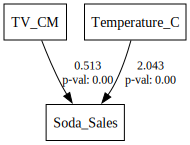

In [6]:
# ============================================================
# SEM のパス図（構造の可視化）
# ============================================================
# sem.semplot(mod, "business_case_SEM.png") は、推定済みの SEM モデル `mod` を
# パス図（path diagram）として画像ファイルに出力する関数。
#
# 理論的には、このパス図は
#   - 観測変数（ここでは TV_CM, Temperature_C, Soda_Sales）
#   - それらを結ぶ因果パス（回帰係数付きの矢印）
#   - 誤差項（残差）のノード
# を含んだ「構造方程式モデルのグラフ表現」に対応している。
#
# 今回の単純なモデルでは、
#   TV_CM  →\
#            \
#             →  Soda_Sales
#            /
#   Temperature_C →
#
# のような「TVCM と気温が Soda_Sales に向かって矢印を出す」構造が描かれ、
# 各矢印の上に推定された回帰係数（β1, β2）が表示される。
#
# これにより、
# - 数式（Soda_Sales ~ TV_CM + Temperature_C）
# - 推定結果（inspect で見た係数）
# - 因果グラフ（パス図）
# の 3 つが一貫しているかを目視で確認できる。
#
# 出力ファイル "business_case_SEM.png" はカレントディレクトリに保存されるので、
# レポートやスライドに貼り付けて「ビジネスケースの因果構造」を説明する図として
# そのまま利用できる。
#
# ※環境によっては、内部で Graphviz が必要になる場合があるため、
#   もしエラーが出る場合は `graphviz` のインストール状況も確認するとよい。
sem.semplot(mod, "business_case_SEM.png")